In [193]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import keras
import tensorflow as tf
import random

In [194]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import random
#import tqdm
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [195]:
#Importing drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
#Setting file paths in drive
path = '/content/drive/MyDrive/CourseWork/Deeplearning for Vision and NLP/litter_detection_model'

#raw images
raw_image_path = path + '/raw_images'
punalur_raw_image_path = raw_image_path + '/Punalur/'
falkirk_raw_image_path = raw_image_path + '/Falkirk'

#annotated images
annotated_image_path = path + '/annotated_images'
punalur_annotated_image_path = annotated_image_path + '/Punalur'
falkirk_annotated_image_path = annotated_image_path + '/Falkirk'


(4160, 3120, 3)


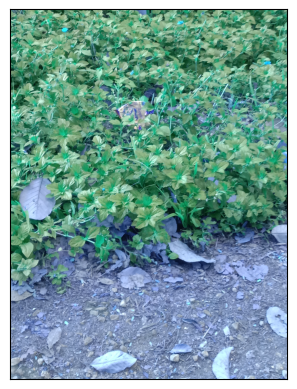

In [197]:
punalur_raw_images = [image for image in os.listdir(raw_image_path+'/Punalur/')]


first_image = cv2.imread(punalur_raw_image_path+punalur_raw_images[3], cv2.COLOR_BGR2RGB)
print(first_image.shape)

plt.imshow(first_image)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


(256, 256, 3)

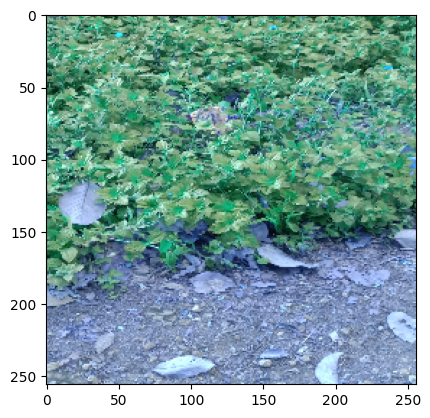

In [198]:
resized_image = cv2.resize(first_image, (256, 256))
plt.imshow(resized_image)
resized_image.shape

(256, 256, 3)

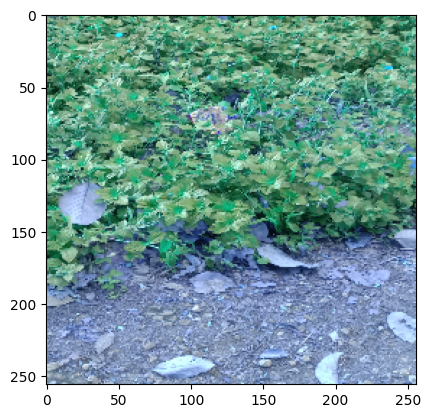

In [199]:
normalized_image = resized_image.astype(np.float32) / 255.0

plt.imshow(normalized_image)
normalized_image.shape

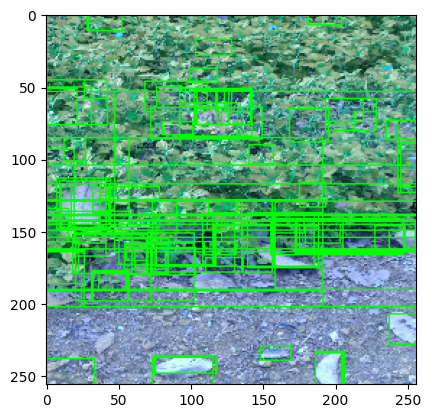

In [200]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

ss.setBaseImage(normalized_image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = normalized_image.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [201]:
txt_files = [f for f in os.listdir(punalur_annotated_image_path) if f.lower().endswith('.txt')]
txt_files.remove('classes.txt')

# Reading the content of each .txt file

annotated_punalur_files = []
for txt_file in txt_files:
    # print(txt_file)
    file_path = os.path.join(punalur_annotated_image_path, txt_file)
    with open(file_path, 'r') as f:
        cols = ['label_class', 'x_center', 'y_center', 'width', 'height']
        content = pd.read_csv(f, sep=' ', names = cols)
    annotated_punalur_files.append({txt_file:content})

In [202]:
def get_rectangle_object_from_image(image, x, y, w, h):
  # Cropping the object and resizing to the standard size
  cropped_image = image[y : y+h, x : x+w]
  resized_image = cv2.resize(cropped_image, (224, 224), interpolation = cv2.INTER_AREA)
  # resized_image = cv2.resize(cropped_image, (224, 224), interpolation = cv2.INTER_CUBIC)
  # resized_image = cv2.resize(cropped_image, (224, 224))
  return resized_image


In [203]:
def get_rectangle_coordinates_from_image(image, x_center, y_center, height, width):
  H, W, _ = image.shape
  x1 = int((x_center - width / 2) * W)
  y1 = int((y_center - height / 2) * H)
  x2 = int((x_center + width / 2) * W)
  y2 = int((y_center + height / 2) * H)
  return x1, y1, x2, y2

In [204]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [205]:
def perform_image_preprocessing(img):
  resized_image = cv2.resize(img, (256, 256))
  normalized_image = resized_image.astype(np.float32) / 255.0

  return normalized_image

In [206]:
max_proposal = 2000
max_samples = 30
IOU_treshold_plane = 0.7
IOU_treshold_background = 0.3

In [207]:

def get_train_images_labels(annotated_files_list):

  train_images = []
  train_labels = []

  for annotated_file in tqdm(annotated_files_list, desc="Processing images"):

    #Extracting file name to fetch the corresponding raw image
    file_name = list(annotated_file.keys())[0]

    # Reading the corresponding raw image
    image_path = os.path.join(punalur_raw_image_path, file_name.replace(".txt", ".jpg"))
    base_image = cv2.imread(image_path)
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
    base_image_copy = base_image.copy()

    base_image = perform_image_preprocessing(base_image)

    annotated_coordinate_list = []

    for entry in annotated_file:

      #Iterating through each lines of the annotated file(ie, different object labels)
      df = annotated_file[entry]
      for index, row in df.iterrows():
        class_label = row['label_class']
        x_center = row['x_center']
        y_center = row['y_center']
        height = row['height']
        width = row['width']
      
      x1, y1, x2, y2 = get_rectangle_coordinates_from_image(base_image, x_center, y_center, height, width)
      annotated_coordinate_dict = {'x1':x1, 'y1': y1, 'x2': x2, 'y2': y2}
      annotated_coordinate_list.append(annotated_coordinate_dict)
      # cv2.rectangle(base_image,(x1,y1),(x2,y2),(255,0,0), 10)

    cv2.setUseOptimized(True);
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(base_image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    
    counter = 0
    flag = 0
    fflag = 0
    bflag = 0
    falsecounter = 0

    for index, result in enumerate(ssresults):
      if index < max_proposal and flag == 0:
        for box_values in annotated_coordinate_list:
          x, y, w, h = result
          iou = get_iou(box_values,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
          cv2.rectangle(base_image,(x,y),(x + w,y + h),(255,0,0), 5)
          plt.imshow(base_image)
          if counter < max_samples:
            if iou > IOU_treshold_plane:
              train_images.append(get_rectangle_object_from_image(base_image, x, y, w, h))
              train_labels.append(1)
              counter += 1
            else:
              fflag = 1
            if falsecounter < max_samples:
              if iou < IOU_treshold_background:
                train_images.append(get_rectangle_object_from_image(base_image, x, y, w, h))
                train_labels.append(0)
                falsecounter += 1
            else:
              bflag = 1
          if fflag == 1 and bflag == 1:
            flag = 1

  return train_images, train_labels


Processing images:   0%|          | 0/43 [00:00<?, ?it/s]

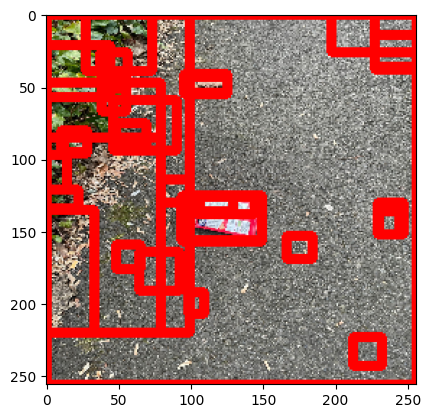

In [230]:
X_new, Y_new = get_train_images_labels(annotated_punalur_files)
X_new = np.array(X_new)
Y_new = np.array(Y_new)
# X_new = preprocess_input(X_new)

In [231]:
num_classes = 1  #Class: Trash

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
# predictions = Dense(num_classes, activation='softmax')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs = base_model.input, outputs=predictions)

In [232]:
X_new = preprocess_input(X_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y_new,test_size=0.10)

In [233]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 100 
batch_size = 10

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test))

Epoch 1/100
117/117 [==============================] - 29s 198ms/step - loss: 3380396.0000 - accuracy: 0.9889 - val_loss: 76.0062 - val_accuracy: 0.9846
Epoch 2/100
117/117 [==============================] - 21s 176ms/step - loss: 15951.2295 - accuracy: 0.9923 - val_loss: 8259.3613 - val_accuracy: 0.9846
Epoch 3/100
117/117 [==============================] - 20s 173ms/step - loss: 7648.3115 - accuracy: 0.9923 - val_loss: 1181.3547 - val_accuracy: 0.9846
Epoch 4/100
117/117 [==============================] - 21s 178ms/step - loss: 4134.0825 - accuracy: 0.9794 - val_loss: 2145.0464 - val_accuracy: 0.9846
Epoch 5/100
117/117 [==============================] - 21s 179ms/step - loss: 1564.0342 - accuracy: 0.9803 - val_loss: 3160.5483 - val_accuracy: 0.9846
Epoch 6/100
117/117 [==============================] - 21s 179ms/step - loss: 9893.5703 - accuracy: 0.9837 - val_loss: 88881.3672 - val_accuracy: 0.9846
Epoch 7/100
117/117 [==============================] - 20s 174ms/step - loss: 67744.6

KeyboardInterrupt: ignored

In [234]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


5/5 [==============================] - 2s 286ms/step - loss: 0.0933 - accuracy: 0.9846
Test loss: 0.09332327544689178, Test accuracy: 0.9846153855323792
